In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --upgrade gensim
!pip install numpy==1.20.3

# **Paraphrase Identification**

# **Download and read dataset**

# **Microsoft Research Paraphrase Corpus**

In [3]:
import pandas as pd

# train https://drive.google.com/file/d/17eLq5Ng5yfbX9tLq2tdiOdscO0ea8xK5/view?usp=sharing
# valid https://drive.google.com/file/d/1Y-68UagW14hwJXNyaR2HnML5jEwvjQlj/view?usp=sharing
# test https://drive.google.com/file/d/1P_HLLvGq15gsgDl5P6QYrHkTlkcytMdr/view?usp=sharing

!gdown --id 17eLq5Ng5yfbX9tLq2tdiOdscO0ea8xK5
!gdown --id 1Y-68UagW14hwJXNyaR2HnML5jEwvjQlj
!gdown --id 1P_HLLvGq15gsgDl5P6QYrHkTlkcytMdr

train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

Downloading...
From: https://drive.google.com/uc?id=17eLq5Ng5yfbX9tLq2tdiOdscO0ea8xK5
To: /content/train.csv
100% 951k/951k [00:00<00:00, 62.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Y-68UagW14hwJXNyaR2HnML5jEwvjQlj
To: /content/valid.csv
100% 105k/105k [00:00<00:00, 28.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P_HLLvGq15gsgDl5P6QYrHkTlkcytMdr
To: /content/test.csv
100% 444k/444k [00:00<00:00, 63.4MB/s]


# **Q1**

In [4]:
# remove punctuation marks, non-alphabetic tokens, and lowercase the tokens
def clean_data(data):

  tokenized_data = []

  for d in data:
    tokens = d.split()
    translation_table = str.maketrans('', '', "\"#$%&'()*+,-/:;<=>?@[\]^_`{|}~،؟!❊#$٪^&*)(ـ+=-؛:{}")
    tokens = [w.translate(translation_table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokenized_data.append(tokens)

  return tokenized_data

In [5]:
import numpy as np

length = []

for index, row in train.iterrows():
  length.append(len(row.sentence1.split(" ")))
  length.append(len(row.sentence2.split(" ")))

print(np.mean(length))

18.972063232488416


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_SEQ_LENGTH = 20

# clean data
cleaned_train_data = clean_data(train.sentence1.append(train.sentence2))
cleaned_valid_data = clean_data(valid.sentence1.append(valid.sentence2))
cleaned_test_data = clean_data(test.sentence1.append(test.sentence2))

# create the tokenizer and fit it on the input text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_train_data)

# tokenize the input text into encoded numbers
train_sequences = tokenizer.texts_to_sequences(cleaned_train_data)
valid_sequences = tokenizer.texts_to_sequences(cleaned_valid_data)
test_sequences = tokenizer.texts_to_sequences(cleaned_test_data)

# pad the input text 
train_sequences = pad_sequences(train_sequences, maxlen=MAX_SEQ_LENGTH, padding='post')
valid_sequences = pad_sequences(valid_sequences, maxlen=MAX_SEQ_LENGTH, padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

# separate sentence1 and sentence2
train_sent1 = train_sequences[:len(train)]
train_sent2 = train_sequences[len(train): len(train) * 2]
valid_sent1 = valid_sequences[:len(valid)]
valid_sent2 = valid_sequences[len(valid): len(valid) * 2]
test_sent1 = test_sequences[:len(test)]
test_sent2 = test_sequences[len(test): len(test) * 2]

In [7]:
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index) + 1
EMB_SIZE = 100

In [8]:
# train word2vec 
from gensim.models import Word2Vec

train_words = clean_data(train.sentence1.append(train.sentence2))

w2v_model = Word2Vec(train_words, min_count=1, vector_size=EMB_SIZE, window=3, sg=1)

words = list(w2v_model.wv.key_to_index.keys())
embeddings = w2v_model.wv.vectors

lines = []
for i in range(len(words)):
    line = words[i]
    for j in range(len(embeddings[i])):
        line += ' '
        line += str(embeddings[i][j])
    lines.append(line)

with open('drive/MyDrive/MCI/HW5/MRPC.' + str(EMB_SIZE) + '.vec', 'w') as f:
    for l in lines:
        f.write("%s\n" % l)

In [9]:
import numpy as np

embeddings_index = {}

f = open('drive/MyDrive/MCI/HW5/MRPC.' + str(EMB_SIZE) + '.vec')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.random.random((VOCAB_SIZE, EMB_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# **Q2**

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, losses
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.metrics import *
# from keras_self_attention import SeqSelfAttention

In [11]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):

        self.W = self.add_weight(name="attention_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="attention_bias", shape=(input_shape[1], 1), initializer="zeros")      

        super(Attention, self).build(input_shape)

    def call(self, x):

        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        # return K.sum(output, axis=1)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [12]:
# define model
def get_model(VOCAB_SIZE, EMB_SIZE, MAX_SEQ_LENGTH, embedding_matrix):

  # define layers
  embedding_layer = Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_SEQ_LENGTH, weights=[embedding_matrix], mask_zero=True, name='EmbeddingLayer')
  bilstm_layer = Bidirectional(LSTM(EMB_SIZE, dropout=0.2, activation="tanh", return_sequences=True, recurrent_dropout=0.5))
  att_layer = Attention()


  # sentence1
  sent1_input = Input(shape=(MAX_SEQ_LENGTH,), name='Sentence1')
  sent1_emb = embedding_layer(sent1_input)
  sent1_bilstm = bilstm_layer(sent1_emb)
  sent1_att = att_layer(sent1_bilstm)


  # sentence2
  sent2_input = Input(shape=(MAX_SEQ_LENGTH,), name='Sentence2')
  sent2_emb = embedding_layer(sent2_input)
  sent2_bilstm = bilstm_layer(sent2_emb)
  sent2_att = att_layer(sent2_bilstm)
  
 
  concat_layer = Concatenate(name='concatenate', axis=1)([sent1_att, sent2_att])
  flatten = Flatten()(concat_layer)

  drop_layer1 = Dropout(0.2)(flatten)
  dense_layer1 = Dense(512, activation='relu', name='DenseLayer1')(drop_layer1)
  dense_layer2 = Dense(128, activation='relu', name='DenseLayer2')(drop_layer1)
  dense_layer3 = Dense(64, activation='relu', name='DenseLayer3')(dense_layer2)
  dense_layer4 = Dense(32, activation='relu', name='DenseLayer4')(dense_layer3)
  drop_layer2 = Dropout(0.2)(dense_layer4)

  out = Dense(2, activation='softmax', name='OutputLayer')(drop_layer2)

  model = Model(inputs=[sent1_input, sent2_input], outputs=out)

  optimizer = optimizers.Adam(learning_rate=2e-4)
  loss = losses.binary_crossentropy

  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', Recall(), Precision()])

  return model

In [13]:
model = get_model(VOCAB_SIZE, EMB_SIZE, MAX_SEQ_LENGTH, embedding_matrix)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sentence1 (InputLayer)          [(None, 20)]         0                                            
__________________________________________________________________________________________________
Sentence2 (InputLayer)          [(None, 20)]         0                                            
__________________________________________________________________________________________________
EmbeddingLayer (Embedding)      (None, 20, 100)      1201700     Sentence1[0][0]                  
                                                                 Sentence2[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 20, 200)      160800      EmbeddingLayer[0][0]         

In [14]:
from tensorflow.keras.utils import to_categorical

y_train = np.array(to_categorical(train.label), dtype=int)
y_valid = np.array(to_categorical(valid.label), dtype=int)
y_test = np.array(to_categorical(test.label), dtype=int)

max_epoch = 7

In [15]:
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

class VisualiseAttentionMap(Callback):

        def on_epoch_end(self, epoch, logs=None):
            concatenate_layer_out = Model(inputs=model.input, outputs=model.get_layer('concatenate').output)
            outputs = concatenate_layer_out.predict([test_sent1, test_sent2])

            plt.imshow(outputs[0][:MAX_SEQ_LENGTH], cmap='Blues')

            iteration_no = str(epoch).zfill(3)
            plt.axis('off')
            plt.title(f'Iteration {iteration_no} / {max_epoch} Sentence1')
            plt.savefig('attention1.png')
            plt.show()
            plt.close()
            plt.clf()

            plt.imshow(outputs[0][MAX_SEQ_LENGTH:], cmap='hot')

            iteration_no = str(epoch).zfill(3)
            plt.axis('off')
            plt.title(f'Iteration {iteration_no} / {max_epoch} Sentence2')
            plt.savefig('attention2.png')
            plt.show()
            plt.close()
            plt.clf()

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = '/content/drive/MyDrive/MCI/HW5/bilstm.ckpt'

cp_callback = [ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', mode = 'max', save_best_only=True), EarlyStopping(patience=10)]

Epoch 1/7
29/29 [==============================] - 32s 628ms/step - loss: 0.6495 - accuracy: 0.6705 - recall: 0.6705 - precision: 0.6705 - val_loss: 0.5837 - val_accuracy: 0.7174 - val_recall: 0.7174 - val_precision: 0.7174


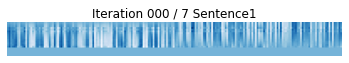

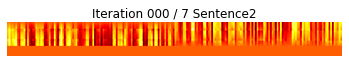

INFO:tensorflow:Assets written to: /content/drive/MyDrive/MCI/HW5/bilstm.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MCI/HW5/bilstm.ckpt/assets


Epoch 2/7
29/29 [==============================] - 17s 579ms/step - loss: 0.6115 - accuracy: 0.6708 - recall: 0.6708 - precision: 0.6708 - val_loss: 0.5820 - val_accuracy: 0.7174 - val_recall: 0.7174 - val_precision: 0.7174


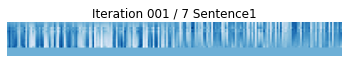

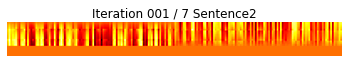

Epoch 3/7
29/29 [==============================] - 16s 565ms/step - loss: 0.6070 - accuracy: 0.6710 - recall: 0.6710 - precision: 0.6710 - val_loss: 0.5802 - val_accuracy: 0.7224 - val_recall: 0.7224 - val_precision: 0.7224


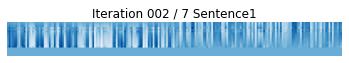

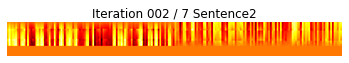

INFO:tensorflow:Assets written to: /content/drive/MyDrive/MCI/HW5/bilstm.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MCI/HW5/bilstm.ckpt/assets


Epoch 4/7
29/29 [==============================] - 17s 576ms/step - loss: 0.6002 - accuracy: 0.6806 - recall: 0.6806 - precision: 0.6806 - val_loss: 0.5760 - val_accuracy: 0.7199 - val_recall: 0.7199 - val_precision: 0.7199


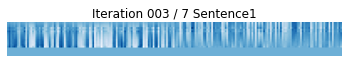

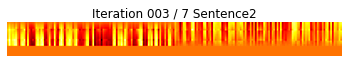

Epoch 5/7
29/29 [==============================] - 17s 573ms/step - loss: 0.5994 - accuracy: 0.6857 - recall: 0.6857 - precision: 0.6857 - val_loss: 0.5767 - val_accuracy: 0.7273 - val_recall: 0.7273 - val_precision: 0.7273


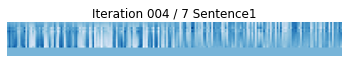

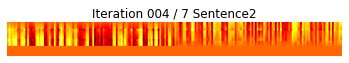

INFO:tensorflow:Assets written to: /content/drive/MyDrive/MCI/HW5/bilstm.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MCI/HW5/bilstm.ckpt/assets


Epoch 6/7
29/29 [==============================] - 17s 572ms/step - loss: 0.5925 - accuracy: 0.6950 - recall: 0.6950 - precision: 0.6950 - val_loss: 0.5727 - val_accuracy: 0.7224 - val_recall: 0.7224 - val_precision: 0.7224


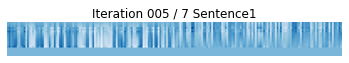

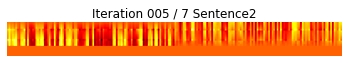

Epoch 7/7
29/29 [==============================] - 17s 570ms/step - loss: 0.5852 - accuracy: 0.7026 - recall: 0.7026 - precision: 0.7026 - val_loss: 0.5798 - val_accuracy: 0.7273 - val_recall: 0.7273 - val_precision: 0.7273


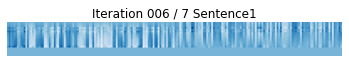

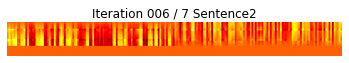

<Figure size 432x288 with 0 Axes>

In [17]:
history = model.fit(
    [train_sent1, train_sent2],
    y_train,
    validation_data = ([valid_sent1, valid_sent2], y_valid),
    epochs=max_epoch,
    verbose=1,
    batch_size=128,
    callbacks=[VisualiseAttentionMap(), cp_callback])

In [18]:
# !zip -r /content/drive/MyDrive/MCI/HW5/bilstm.zip  /content/drive/MyDrive/MCI/HW5/bilstm.ckpt/

In [19]:
# https://drive.google.com/file/d/1u1E10Rp8GaKmM-zo9uAamI1NmIItJSom/view?usp=sharing

# !gdown --id 1u1E10Rp8GaKmM-zo9uAamI1NmIItJSom

In [20]:
# !unzip "bilstm.zip" -d "bilstm"

In [21]:
# from tensorflow.keras.models import load_model

# model = load_model('/content/bilstm/content/drive/MyDrive/MCI/HW5/bilstm.ckpt/')

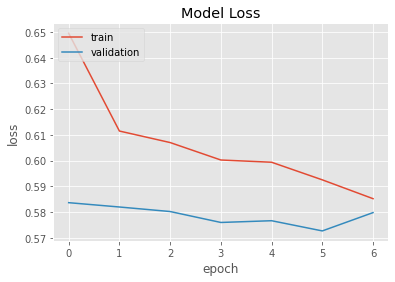

In [22]:
plt.style.use('ggplot')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

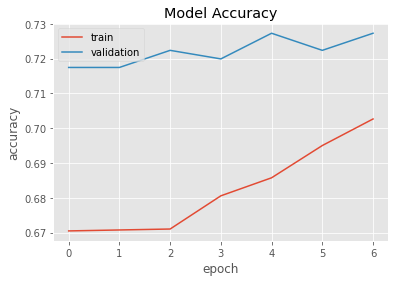

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [24]:
predictions = model.predict([test_sent1, test_sent2])

pred_labels = [np.argmax(predictions[i]) for i in range(len(y_test))]

y_test = test.label.astype(int)

In [25]:
from sklearn.metrics import *

print(classification_report(y_test, pred_labels, target_names=['Class 0', 'Class 1']))

              precision    recall  f1-score   support

     Class 0       0.58      0.22      0.32       578
     Class 1       0.70      0.92      0.79      1147

    accuracy                           0.69      1725
   macro avg       0.64      0.57      0.56      1725
weighted avg       0.66      0.69      0.64      1725



In [26]:
print("Test Accuracy:", accuracy_score(y_test, pred_labels)) 
print('Test Precision (micro):', precision_score(y_test, pred_labels, average='micro'))
print('Test Recall (micro):', recall_score(y_test, pred_labels, average='micro'))
print('Test F1 Score (micro):', f1_score(y_test, pred_labels, average='micro'))
print('Test Precision (macro):', precision_score(y_test, pred_labels, average='macro'))
print('Test Recall (macro):', recall_score(y_test, pred_labels, average='macro'))
print('Test F1 Score (macro):', f1_score(y_test, pred_labels, average='macro'))

Test Accuracy: 0.6852173913043478
Test Precision (micro): 0.6852173913043478
Test Recall (micro): 0.6852173913043478
Test F1 Score (micro): 0.6852173913043478
Test Precision (macro): 0.6395555555555555
Test Recall (macro): 0.5710443672827867
Test F1 Score (macro): 0.5593239556423518


# **Q5**

In [27]:
concatenate_layer_out = Model(inputs=model.input, outputs=model.get_layer('concatenate').output)
outputs = concatenate_layer_out.predict([test_sent1, test_sent2])

In [32]:
def print_attention_weight(data, data_index, tokenized_sent1, tokenized_sent2, MAX_SEQ_LENGTH, tokenizer):

  print("sentence1:")
  print(data.sentence1[data_index])
  print("sentence2:")
  print(data.sentence2[data_index])
  print("*************************")

  sent1 = []
  sent2 = []

  for index in tokenized_sent1[data_index]:
    if index == 0:
      sent1.append('PAD')
    else:
      sent1.append(tokenizer.index_word[index])

  for index in tokenized_sent2[data_index]:
    if index == 0:
      sent2.append('PAD')
    else:
      sent2.append(tokenizer.index_word[index])

  print("tokenized sentence1:")
  print(sent1)
  print("tokenized sentence2:")
  print(sent2)
  print("*************************")
  print()

  weights1 = [np.mean(w) for w in outputs[data_index][:MAX_SEQ_LENGTH]]
  weights2 = [np.mean(w) for w in outputs[data_index][MAX_SEQ_LENGTH:]]

  df = pd.DataFrame([sent1, weights1, sent2, weights2], index=['sentence1', 'weight1', 'sentence2', 'weight2'])
  print(df.T)

In [36]:
data_index = 1000
print_attention_weight(test, data_index, test_sent1, test_sent2, MAX_SEQ_LENGTH, tokenizer)
print()
print("*************************")
print("prediction:", pred_labels[data_index])
print("true labels:", y_test[data_index])

sentence1:
Intel sells the current top Pentium for US$637 in quantities of 1,000.
sentence2:
Intel's current Pentium 4 chips have 512K bytes of cache.
*************************
tokenized sentence1:
['intel', 'sells', 'the', 'current', 'top', 'pentium', 'for', 'in', 'quantities', 'of', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
tokenized sentence2:
['intels', 'current', 'pentium', 'chips', 'have', 'bytes', 'of', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
*************************

     sentence1      weight1 sentence2      weight2
0        intel  0.000599871    intels   0.00045568
1        sells   0.00036542   current  0.000135914
2          the  0.000280666   pentium  0.000117305
3      current  0.000279319     chips -2.27943e-06
4          top  0.000268747      have -0.000104018
5      pentium  0.000241564     bytes -4.94211e-05
6          for  0.000219837        of  2.69922e-05
7           in  0.000210848     

In [37]:
data_index = 240
print_attention_weight(test, data_index, test_sent1, test_sent2, MAX_SEQ_LENGTH, tokenizer)
print()
print("*************************")
print("prediction:", pred_labels[data_index])
print("true labels:", y_test[data_index])

sentence1:
That second dossier, passed to journalists during Mr Blair's trip to Washington, said it drew on "a number of sources, including intelligence material".
sentence2:
That second dossier, passed to journalists on Mr Blair's trip to Washington to discuss war plans, said it drew upon "a number of sources, including intelligence material".
*************************
tokenized sentence1:
['dossier', 'passed', 'to', 'journalists', 'during', 'mr', 'blairs', 'trip', 'to', 'washington', 'said', 'it', 'drew', 'on', 'a', 'number', 'of', 'sources', 'including', 'intelligence']
tokenized sentence2:
['on', 'mr', 'blairs', 'trip', 'to', 'washington', 'to', 'discuss', 'war', 'plans', 'said', 'it', 'drew', 'upon', 'a', 'number', 'of', 'sources', 'including', 'intelligence']
*************************

       sentence1      weight1     sentence2      weight2
0        dossier  0.000452775            on  0.000701783
1         passed  0.000434412            mr   0.00101656
2             to  0.000359